# Bird Species Classifier for AML project using TensorFlow
## University of Vienna, SS 2022
---
### Goal: An image recognition model
#### Open Questions:
* Which methods to use? 
* Which model to train?
* What is the class_dict.csv for?
* Do we need both valid set and test set?

In [84]:
import numpy as np
import pandas as pd

import tensorflow as tf
import keras_preprocessing #?
from tensorflow.keras import layers
from tensorflow.keras import layers,mixed_precision

# Model Selection
from sklearn.metrics import confusion_matrix, classification_report
# To search directories
import os
import glob
# To visualize data
import PIL # for image files
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set_style('darkgrid')

# 1. Examine and understand data
## CSV data
The ``birds.csv`` contains information of the dataset. Let's look into the structure of the data.

In [85]:
# Create a dataframe from the csv
birds_df = pd.read_csv("../input/100-bird-species/birds.csv")
# clean column names
birds_df.columns = [col.replace(' ', '_').lower() for col in birds_df.columns]
birds_df.head()

,class_index,filepaths,labels,data_set
0,0,train/ABBOTTS BABBLER/001.jpg,ABBOTTS BABBLER,train
1,0,train/ABBOTTS BABBLER/002.jpg,ABBOTTS BABBLER,train
2,0,train/ABBOTTS BABBLER/003.jpg,ABBOTTS BABBLER,train
3,0,train/ABBOTTS BABBLER/004.jpg,ABBOTTS BABBLER,train
4,0,train/ABBOTTS BABBLER/005.jpg,ABBOTTS BABBLER,train


In [86]:
birds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62388 entries, 0 to 62387
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   class_index  62388 non-null  int64 
 1   filepaths    62388 non-null  object
 2   labels       62388 non-null  object
 3   data_set     62388 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.9+ MB


In [87]:
birds_df.value_counts("data_set").head()

data_set
train    58388
test      2000
valid     2000
dtype: int64

In [88]:
# Frequency of bird species in the whole dataset
print("|species | f|")
birds_df.value_counts("class_index")

|species | f|


class_index
224    259
144    243
287    243
363    227
396    224
      ... 
129    130
122    130
346    130
326    130
62     130
Length: 400, dtype: int64

In [89]:
# Look at csv entries for one single bird

#mask = birds_df['labels'].str.contains("ABBOTTS BABBLER") # Search for text fragment
#mask = birds_df.query('labels == "ABBOTTS BABBLER"') # query for name (case sensitive!)
mask = birds_df.loc[birds_df['class_index'] == 0]
print(mask.value_counts("data_set"))
mask

data_set
train    166
test       5
valid      5
dtype: int64


,class_index,filepaths,labels,data_set
0,0,train/ABBOTTS BABBLER/001.jpg,ABBOTTS BABBLER,train
1,0,train/ABBOTTS BABBLER/002.jpg,ABBOTTS BABBLER,train
2,0,train/ABBOTTS BABBLER/003.jpg,ABBOTTS BABBLER,train
3,0,train/ABBOTTS BABBLER/004.jpg,ABBOTTS BABBLER,train
4,0,train/ABBOTTS BABBLER/005.jpg,ABBOTTS BABBLER,train
...,...,...,...,...
60388,0,valid/ABBOTTS BABBLER/1.jpg,ABBOTTS BABBLER,valid
60389,0,valid/ABBOTTS BABBLER/2.jpg,ABBOTTS BABBLER,valid
60390,0,valid/ABBOTTS BABBLER/3.jpg,ABBOTTS BABBLER,valid
60391,0,valid/ABBOTTS BABBLER/4.jpg,ABBOTTS BABBLER,valid


### Image data

In [90]:
# File directories
root_dir = "../input/100-bird-species"
train_dir = "../input/100-bird-species/train"
valid_dir = "../input/100-bird-species/valid"
test_dir = "../input/100-bird-species/test"
pretest_dir = "../input/100-bird-species/images to test"
dirs = [pretest_dir, train_dir, valid_dir, test_dir]

### Plot random birds

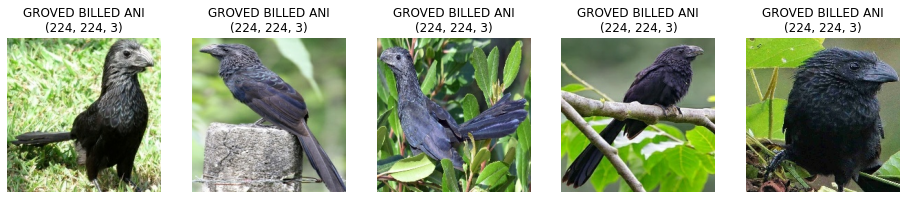

In [91]:
def plot_random_bird(dirname):
    import random
    """
    takes the directory as input and prints 5 random images from the randomly choosen class.
    """
    target_class = random.choice(os.listdir(dirname))
    target_folder = os.path.join(dirname,target_class)
    random_image = random.sample(os.listdir(target_folder),5)
 
    plt.figure(figsize=(16,5))
    for i in range(5):
        
        plt.subplot(1,5,i+1)
        img = tf.io.read_file(os.path.join(target_folder,random_image[i]))
        img = tf.io.decode_image(img)
        plt.imshow(img)
        plt.title(f'{target_class}\n{img.shape}')
        plt.axis(False)
        
plot_random_bird(valid_dir)

../input/100-bird-species/valid/MALLARD DUCK/5.jpg
File shape:  (224, 224, 3) 

../input/100-bird-species/valid/MALLARD DUCK/1.jpg
File shape:  (224, 224, 3) 

../input/100-bird-species/valid/MALLARD DUCK/4.jpg
File shape:  (224, 224, 3) 

../input/100-bird-species/valid/MALLARD DUCK/3.jpg
File shape:  (224, 224, 3) 

../input/100-bird-species/valid/MALLARD DUCK/2.jpg
File shape:  (224, 224, 3) 



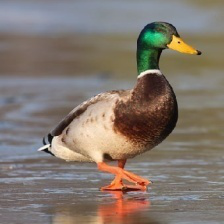

In [92]:
def showFirstBird(bird_name="MALLARD DUCK"):
    """
    Print out file paths of images in the valid_dir and show the first image of a given species.
    """
    import glob
    img_files = []
    for img in glob.glob(os.path.join(valid_dir, bird_name)+"/*"):
        img_files.append(img)
        
    for i in img_files:
        print(i) # Print file path
        ifile = tf.io.read_file(i) # Reads the contents of file
        img_dec = tf.io.decode_image(ifile) # Decodes an image file
        print("File shape: ", img_dec.shape, "\n")
        
    img = PIL.Image.open(str(img_files[0]))
    return img
    
showFirstBird()

# Prepare data for model

### Generate tf.data.Dataset objects from image files in directories

In [93]:
"""
GPUs and TPUs can radically reduce the time required to execute a single training step. 
Achieving peak performance requires an efficient input pipeline that delivers data for 
the next step before the current step has finished. The tf.data API helps to build flexible 
and efficient input pipelines.
~ https://www.tensorflow.org/guide/data_performance
"""
IMAGE_SIZE=(224,224) # constant value

train_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=train_dir,
    labels='inferred',
    label_mode='categorical',
    batch_size=32, # default
    image_size=IMAGE_SIZE,
    shuffle=True   # default
)
class_names = train_data.class_names
num_classes = len(class_names)

val_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=valid_dir,
    labels='inferred',
    label_mode='categorical',
    batch_size=32, # default
    image_size=IMAGE_SIZE,
    shuffle=True   # default
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=test_dir,
    labels='inferred',
    label_mode='categorical',
    batch_size=32, # default
    image_size=IMAGE_SIZE,
    shuffle=False
)
#---------------------------------------------------------------#
"""
The tf.data API provides the tf.data.Dataset.prefetch transformation. It can be used 
to decouple the time when data is produced from the time when data is consumed. In particular, 
the transformation uses a background thread and an internal buffer to prefetch elements from 
the input dataset ahead of the time they are requested. The number of elements to prefetch 
should be equal to (or possibly greater than) the number of batches consumed by a single training step. 
You could either manually tune this value, or set it to tf.data.AUTOTUNE, which will prompt the 
tf.data runtime to tune the value dynamically at runtime.
~ https://www.tensorflow.org/guide/data_performance
"""

# Output the number of classes found in the directory 
train_data_pf = train_data.prefetch(buffer_size = tf.data.AUTOTUNE)
val_data_pf = val_data.prefetch(buffer_size = tf.data.AUTOTUNE)
test_data_pf = test_data.prefetch(buffer_size = tf.data.AUTOTUNE)

Found 58388 files belonging to 400 classes.
Found 2000 files belonging to 400 classes.
Found 2000 files belonging to 400 classes.


In [94]:
train_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 400)), types: (tf.float32, tf.float32)>

# The Model 
## Model architecture
Source: http://bit.ly/2lXXdw5

### Questions:
- What is ``tf.keras.layers.Conv2D`` ?
- What is ``tf.keras.layers.MaxPooling2D`` ?
- What is ``tf.keras.layers.Flatten`` ?
- What is ``tf.keras.layers.Dropout`` ?
- What is ``tf.keras.layers.Dense`` ?
- What is ```` ?

- ...

In [95]:
INPUT_SHAPE=(224,224,3) # constant value

# Defining the architecture of the CNN (Convolutional Neural Network)
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=INPUT_SHAPE),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    # Flatten the results to feed into a DNN (Dense Neural Network)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [96]:
model

## Compile and train model 

### Links:
- TF model.fit() -> https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit
- ...

In [97]:
model.summary()

model.compile(
    loss='categorical_crossentropy', 
    optimizer='rmsprop', 
    metrics=['accuracy']
)

history = model.fit( ,
    train_data, 
    epochs=25, 
    steps_per_epoch=20, 
    validation_data=valid_data, 
    validation_steps=3,
    verbose=1, 
)

model.save("rps.h5")

SyntaxError: invalid syntax (1010243388.py, line 9)

# Results
## Visualize Training

In [ ]:
#import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

---
# README
after the first meeting

### Aufteilung
- keras tensorflow - Clemens
- pytorch - Jakob
- PCA + preprocessing - Lena 


### Methoden 
- pca?
- image segementation
- Wie laden wir die Bilder von der CSV ins Notebook?
- Wieviele Datenreihen brauchen wir? 
data set
| train    58388 | test      2000 | valid     2000 |


# Links
## Good Notebook for reference
### https://www.kaggle.com/code/ashwinshetgaonkar/bird-classifier-tensorflow-beginner

## Learn TensorFlow in this notebook
### http://bit.ly/2lXXdw5